# **Module 4: Diagnostic Systems**
## DAT410

### Group 29 
### David Laessker, 980511-5012, laessker@chalmers.se

### Oskar Palmgren, 010529-4714, oskarpal@chalmers.se



We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions.

___


## 1) Article summary and take-aways

The first paper by Wolberg et al. (1994) focuses on development of an interactive computer system that diagnoses breast cancer from FNA slides (fine needle aspirate). By utilising image analysis and machine learning, their system demonstrated high accuracy, which highlighted the potential of combining ML with digital image to enhance accuracy of breast FNAs diagnoses.

*The Mythos of Model Interpretability* (2018) discusses the concept of interpretability in machine learning models and its complexity. Transparency in the model decisions and post-hoc interpretations of model outputs are suggested as the main approaches. Models should either be understandable by design or provided with clear explanations of the results in order to achieve trust and fairness.

Our main takeaways from both research papers are the potential and challenges of applying machine learning to areas such as medical diagnostics. Significantly improving the accuracy of a diagnosis with ML is promising, however, we need to ensure that the models used are transparent and easily interpretable for this kind of complicated decision making.


___
## 2) Implementation

### 2.1) Rule-based classifier

For the rule-based classifier, we try two different approaches: 

*(a)*. Based on the supplied data, assuming that we know which cells are malignant/benign from the label column and using the respective data to determine what is abnormal.

*(b)*. Based on the supplied data, but we dont know the labels of each cell. We use the data to calculate an averages and standard deviations to define ourselves what is abnormal.

For the first approach (a)... **describe the model**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [3]:
# load dataset as a df
data = pd.read_pickle('wdbc.pkl')

# show the first few rows
data.head()

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
class Rule_Classifier:
    def __init__(self, dataframe):
        self.data = dataframe
        self.big_differences = {}
        self.non_maligant = self.data[self.data['malignant'] == 0].drop('malignant', axis=1)
        self.maligant = self.data[self.data['malignant'] == 1].drop('malignant', axis=1)
        for column in self.data.drop('malignant', axis=1).columns:
            mal_mean = self.maligant[column].mean()
            non_mean = self.non_maligant[column].mean()
            mal_std = self.maligant[column].std()
            non_std = self.non_maligant[column].std()
            if abs(mal_mean - non_mean) > (mal_std + non_std):
                self.big_differences[column] = (non_mean, mal_mean)

    def predict(self, data):
        data['manual_classification'] = 0
        for index, row in data.iterrows():
            non_count = 0
            mal_count = 0
            for column in self.big_differences:
                if abs(row[column] - self.big_differences[column][0]) < abs(row[column] - self.big_differences[column][1]):
                    non_count += 1
                else:
                    mal_count += 1
            if non_count > mal_count: # Tweakable parameter ;)
                data.at[index, 'manual_classification'] = 0
            else:
                data.at[index, 'manual_classification'] = 1
        return data['manual_classification']
    
    def score(self, data):
        correct = 0
        for index, row in data.iterrows():
            if row['manual_classification'] == row['malignant']:
                correct += 1
        accuracy = correct / len(data)
        return accuracy

In [5]:
# Create the rule based classifier
rule_classifier = Rule_Classifier(data)

# Predict the class of the data
data['manual_classification'] = rule_classifier.predict(data)

# Calculate the accuracy of the classifier
accuracy = rule_classifier.score(data)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.907


### 2.1 b)

A different approach where we do not know the actual labels, only use the features to predict. We calculate the average $\mu$ and standard deviation $\sigma$, and define abnormal as $\mu \pm k\sigma$. We set $k=2$, which statistically encompasses about $95 \%$ of the data and results in the data in the $2.5$-th and $97.5$-th percentiles being considered abnormal. Here we assume that the given data is normally distributed, which is not really the case when looking at the histogram plots below. 

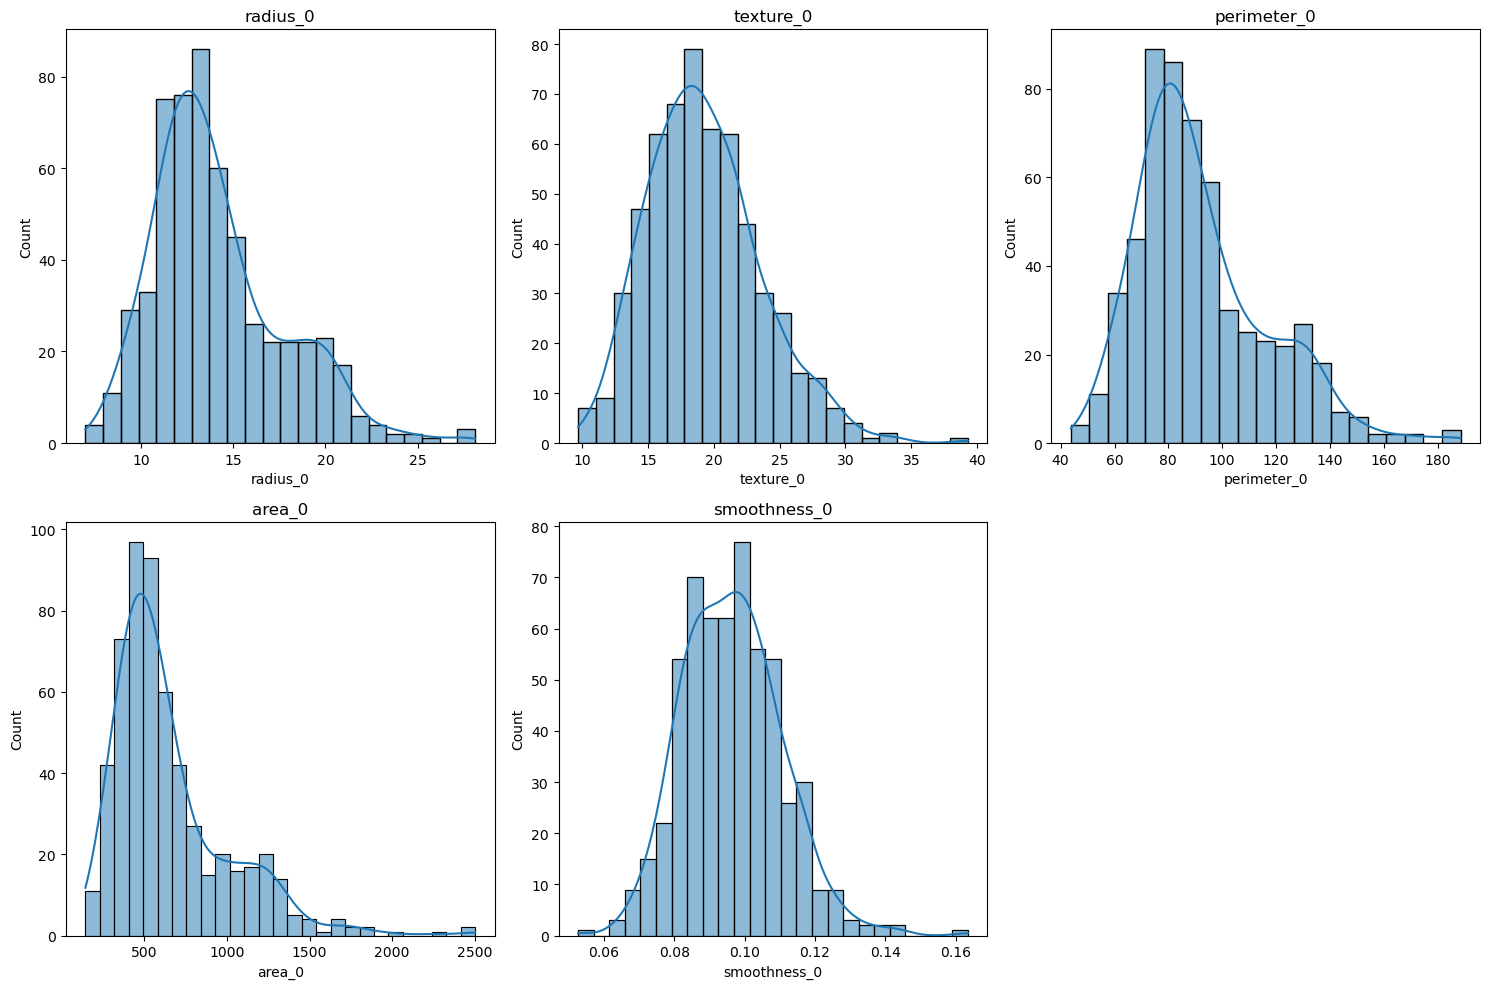

In [6]:

features_to_plot = ['radius_0', 'texture_0', 'perimeter_0', 'area_0', 'smoothness_0']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()


#### also plot the mean?


In [7]:
benign = data[data['malignant'] == 0]
malignant = data[data['malignant'] == 1]

features = ['radius_0', 'perimeter_0', 'area_0', 'concavity_0', 'concave points_0', 'compactness_0', 'texture_0', 'smoothness_0', 'symmetry_0']

data_stats = data[features].agg(['mean', 'std'])

#print(data_stats)


def RB_classifier(row, stats, features):
    '''
    Rule based classifier, goes through all the rows of data feature by feature. 
    If the value is larger than the mean + 2 std or smaller than mean - 2std, 
    then the row is classified as malignant. Otherwise benign
    '''

    for feature in features:
        
        mean = stats[feature]['mean']
        std = stats[feature]['std']
        
        if row[feature] > mean + 2*std or row[feature] < mean - 2*std: 
            return 1
    
    return 0



prediction =  data.copy().apply(RB_classifier, axis=1, args=(data_stats, features,))


accuracy_score(data['malignant'], prediction)


0.6766256590509666

<Axes: >

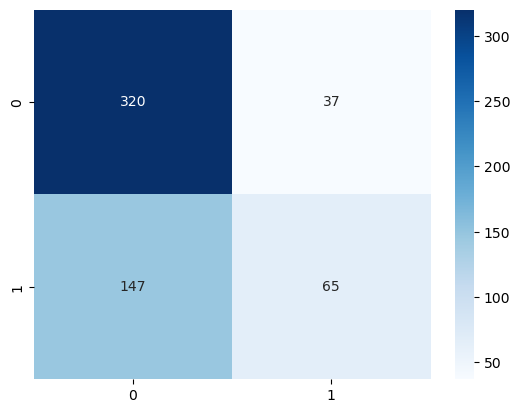

In [8]:
matrix = confusion_matrix(data['malignant'], prediction)
        
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    

We get an accuracy of 67.7%, which is not great. Some possible factors in order to improve the score would be to take into account that the data is not normally distributed, and shift the thresholds for

### 2.2) Random Forest Classifier

In [9]:
data_features = data.drop(columns=['id', 'malignant'])
data_labels = data['malignant']

X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, test_size=0.2, random_state=0)


RF_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)


0.9649122807017544


### 2.3) Own Classifier

In [10]:
# Use decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create the classifier
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.965


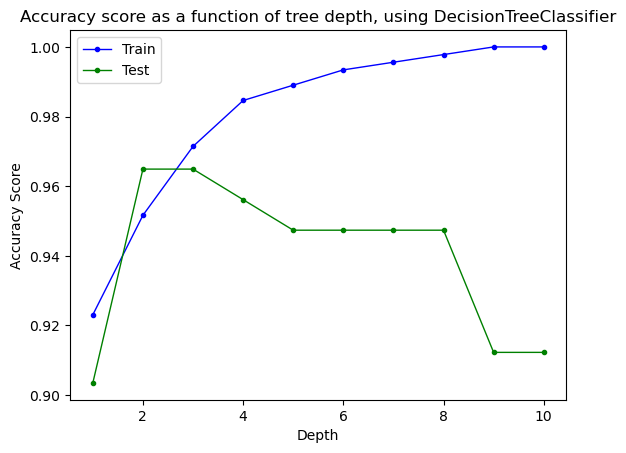

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, test_size=0.2, random_state=0)
depths = range(1, 11)
acc_train = []
acc_test = []
for i in depths:
    DC = DecisionTreeClassifier(max_depth = i)
    DC.fit(X_train, y_train)

    # calculate the accuracy scores
    Yguess_train = DC.predict(X_train)
    acc_train.append(accuracy_score(y_train, Yguess_train))
    
    Yguess_test = DC.predict(X_test)
    acc_test.append(accuracy_score(y_test, Yguess_test))


import matplotlib.pyplot as plt
plt.plot(depths, acc_train, 'o-', lw=1, markersize=3, color='blue', label='Train')
plt.plot(depths, acc_test, 'o-', lw=1, markersize=3, color='green', label='Test')

plt.title("Accuracy score as a function of tree depth, using DecisionTreeClassifier")
plt.ylabel("Accuracy Score")
plt.xlabel("Depth")
plt.legend()
plt.show()

KeyboardInterrupt: 

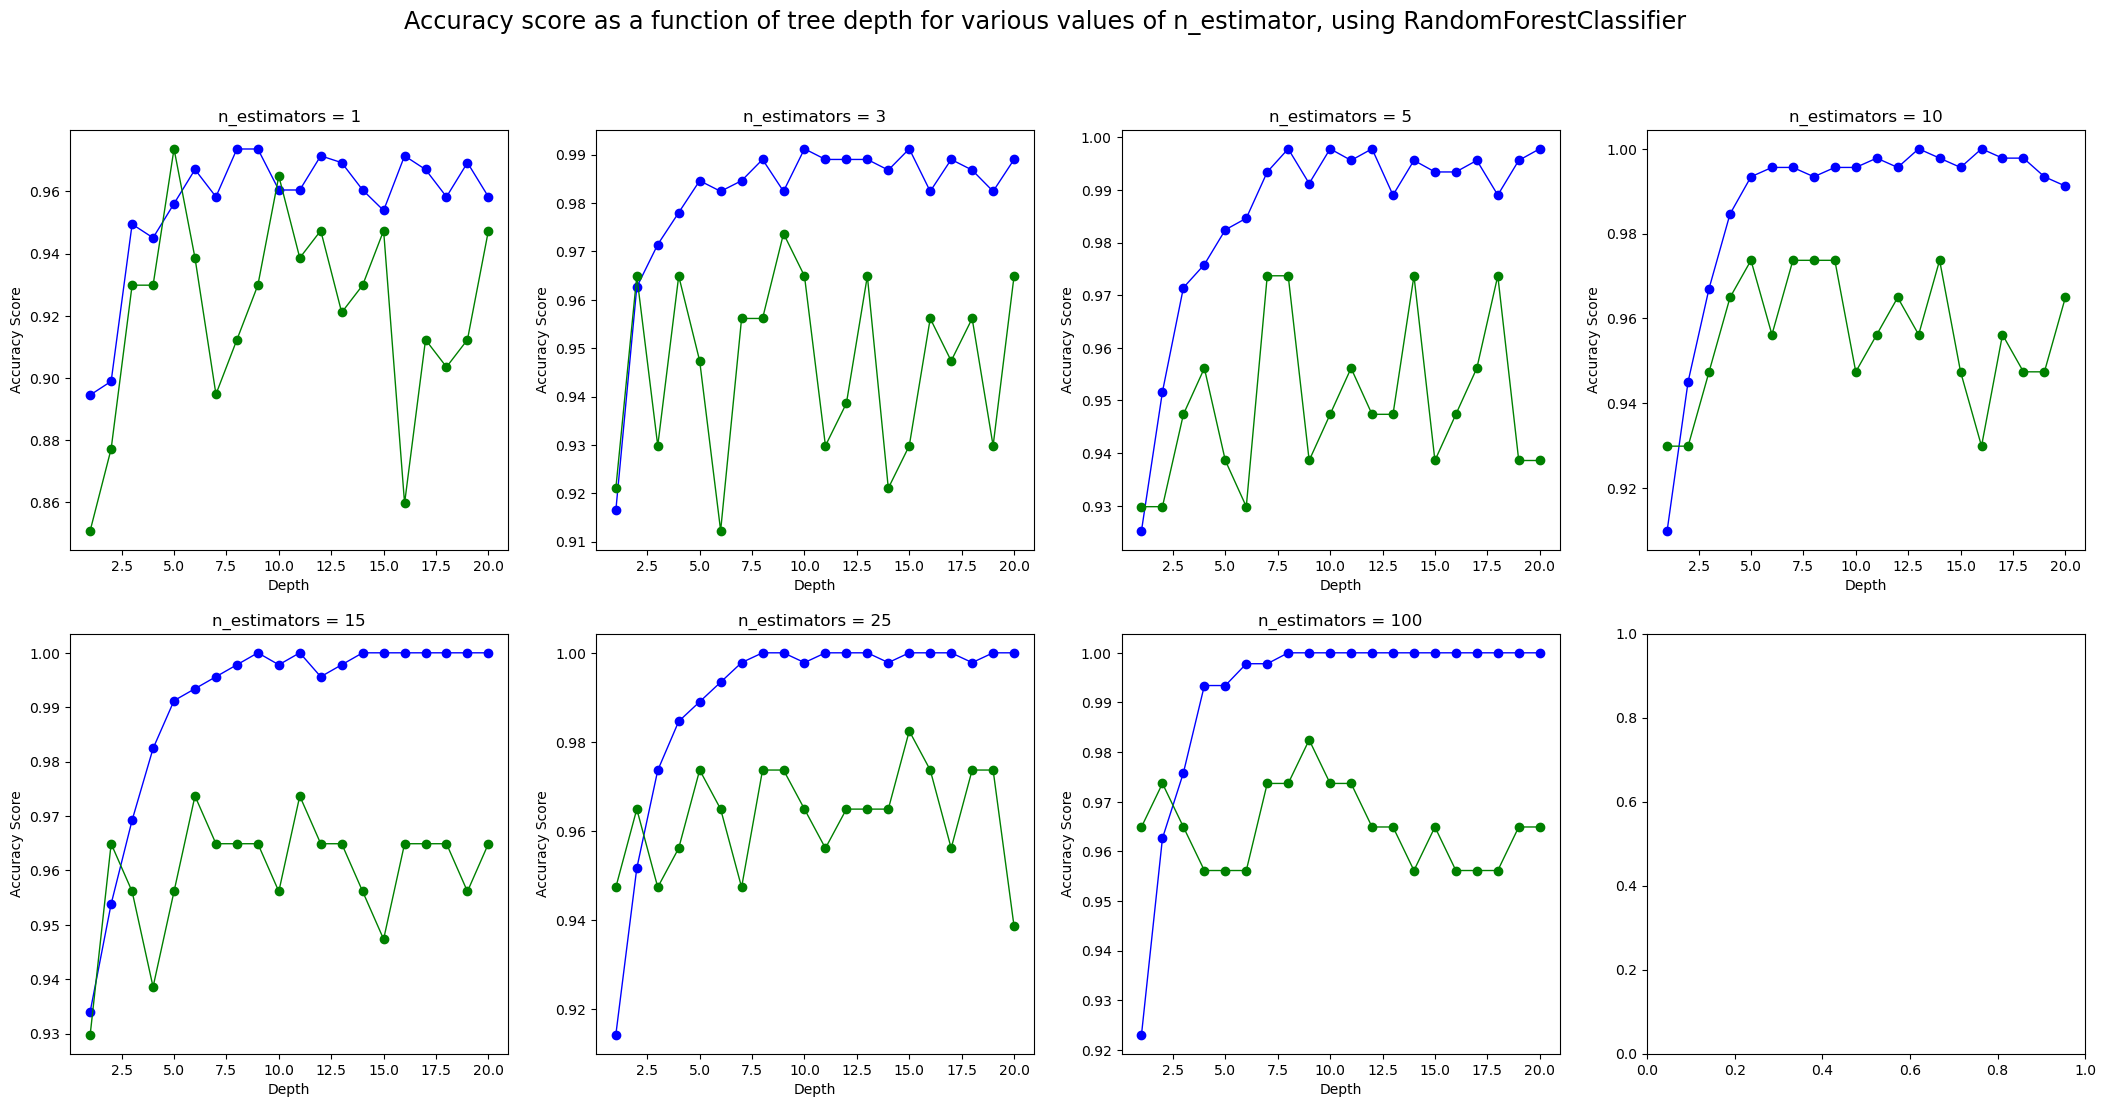

In [12]:
def RForest(Xtr, Xte, Ytr, Yte, max_d, n_est, n_j=None):
    
    acc_tr = [] #accuracies for training data
    acc_te = [] #accuracies for test data

    for i in max_d:
        RF = RandomForestClassifier(n_estimators=n_est, max_depth=i, n_jobs=n_j)
        RF.fit(Xtr, Ytr)
        
        Yguess_tr = RF.predict(Xtr)
        acc_tr.append(accuracy_score(Ytr, Yguess_tr))
        
        Yguess_te= RF.predict(Xte)
        acc_te.append(accuracy_score(Yte, Yguess_te))

    return acc_tr, acc_te

depths = range(1,21)

n_est = [1, 3, 5, 10, 15, 25, 100, 350]

fig, axs = plt.subplots(2, 4, figsize=(26, 12))

fig.suptitle('Accuracy score as a function of tree depth for various values of n_estimator, using RandomForestClassifier', size='xx-large')

k=0
n_j=None

for i in range(2):
    for j in range(4):
        
        if i == 1:
            k = 4
            n_j = -1

        data = RForest(X_train, X_test, y_train, y_test, depths, n_est[j+k], n_j)

        axs[i, j].plot(depths, data[0], 'o-', lw=1, color='blue', label='Train')
        axs[i, j].plot(depths, data[1], 'o-', lw=1, color='green', label='Test')

        axs[i, j].set_title('n_estimators = {}'.format(n_est[j+k]))

        axs[i, j].set_ylabel("Accuracy Score")
        axs[i, j].set_xlabel("Depth")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc = "center left")




In [13]:
#Most important features

RFC = RandomForestClassifier(n_estimators = 100)
RFC.fit(X_train, y_train)


# access feature names and importance scores
feature_names = data_features.columns
importances = RFC.feature_importances_.tolist()


# associate importance scores with feature names and sort in descending order
result = {feature_names[i]: importances[i] for i in range(len(feature_names))}
result_sorted = sorted(result.items(), key=lambda x:x[1], reverse=True)

for res in result_sorted:
    print(res)

('radius_2', 0.13465410663443667)
('concave points_2', 0.12161625410208497)
('concave points_0', 0.10233561763201089)
('perimeter_2', 0.10160505039189659)
('area_2', 0.08997534230155074)
('concavity_0', 0.049282330902062806)
('perimeter_0', 0.04902883881419655)
('manual_classification', 0.04355435449868698)
('area_0', 0.03586741451253866)
('concavity_2', 0.034372543626061784)
('radius_0', 0.02975436581934758)
('area_1', 0.026884378939812707)
('smoothness_2', 0.01819891464147979)
('radius_1', 0.016872862622758108)
('perimeter_1', 0.016205619309193967)
('texture_2', 0.015996345087618477)
('compactness_2', 0.01591688869839132)
('symmetry_2', 0.013544900441390062)
('texture_0', 0.012643683977649858)
('compactness_0', 0.011144804243539244)
('smoothness_0', 0.007513100067926305)
('concave points_1', 0.007448598658137896)
('concavity_1', 0.006929868929717404)
('fractal dimension_2', 0.006657083977148494)
('fractal dimension_1', 0.006429383150287197)
('texture_1', 0.005697568501668602)
('symme

In [104]:
'''
from sklearn.tree import DecisionTreeClassifier

acc_train = []
acc_test = []

depths = range(1,51)

# train classifier on the training data, and test on the training data and testing data respectively
for i in depths:
    DC = DecisionTreeClassifier(max_depth = i)
    DC.fit(Xtrain_encoded, Ytrain)

    # calculate the accuracy scores
    Yguess_train = DC.predict(Xtrain_encoded)
    acc_train.append(accuracy_score(Ytrain, Yguess_train))
    
    Yguess_test = DC.predict(Xtest_encoded)
    acc_test.append(accuracy_score(Ytest, Yguess_test))



plt.plot(depths, acc_train, 'o-', lw=1, markersize=3, color='blue', label='Train')
plt.plot(depths, acc_test, 'o-', lw=1, markersize=3, color='green', label='Test')

plt.title("Accuracy score as a function of tree depth, using DecisionTreeClassifier")
plt.ylabel("Accuracy Score")
plt.xlabel("Depth")
plt.legend()
plt.show()
#################################

from sklearn.ensemble import RandomForestClassifier
import time 


def RForest(Xtr, Xte, Ytr, Yte, max_d, n_est, n_j=None):
    
    acc_tr = [] #accuracies for training data
    acc_te = [] #accuracies for test data

    time_start = time.time() #to measure the computation time for the classifier

    for i in max_d:
        RF = RandomForestClassifier(n_estimators=n_est, max_depth=i, n_jobs=n_j)
        RF.fit(Xtr, Ytr)
        
        Yguess_tr = RF.predict(Xtr)
        acc_tr.append(accuracy_score(Ytr, Yguess_tr))
        
        Yguess_te= RF.predict(Xte)
        acc_te.append(accuracy_score(Yte, Yguess_te))
    
    time_end = time.time()

    n_time = time_end-time_start
    
    return acc_tr, acc_te, n_time

depths = range(1,21)

n_est = [1, 3, 5, 10, 15, 25, 100, 350]

fig, axs = plt.subplots(2, 4, figsize=(26, 12))

fig.suptitle('Accuracy score as a function of tree depth for various values of n_estimator, using RandomForestClassifier', size='xx-large')

k=0
n_j=None

for i in range(2):
    for j in range(4):
        
        if i == 1:
            k = 4
            n_j = -1

        data = RForest(Xtrain_encoded, Xtest_encoded, Ytrain, Ytest, depths, n_est[j+k], n_j)

        axs[i, j].plot(depths, data[0], 'o-', lw=1, color='blue', label='Train')
        axs[i, j].plot(depths, data[1], 'o-', lw=1, color='green', label='Test')

        axs[i, j].set_title('n_estimators = {}, time: {}s'.format(n_est[j+k], round(data[2], 3)))

        axs[i, j].set_ylabel("Accuracy Score")
        axs[i, j].set_xlabel("Depth")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc = "center left")


##################################33


# using Random Forest Classifier
RFC = RandomForestClassifier(n_estimators = 50, max_depth = 8)
RFC.fit(Xtrain_encoded, Ytrain)

# access feature names and importance scores
feature_names = dictvec.feature_names_
importances = RFC.feature_importances_.tolist()


# associate importance scores with feature names and sort in descending order
res = {feature_names[i]: importances[i] for i in range(len(feature_names))}
res_sorted = sorted(res.items(), key=lambda x:x[1], reverse = True)

res_sorted = np.array(res_sorted[0:10])

print(res_sorted)

'''

'\nfrom sklearn.tree import DecisionTreeClassifier\n\nacc_train = []\nacc_test = []\n\ndepths = range(1,51)\n\n# train classifier on the training data, and test on the training data and testing data respectively\nfor i in depths:\n    DC = DecisionTreeClassifier(max_depth = i)\n    DC.fit(Xtrain_encoded, Ytrain)\n\n    # calculate the accuracy scores\n    Yguess_train = DC.predict(Xtrain_encoded)\n    acc_train.append(accuracy_score(Ytrain, Yguess_train))\n    \n    Yguess_test = DC.predict(Xtest_encoded)\n    acc_test.append(accuracy_score(Ytest, Yguess_test))\n\n\n\nplt.plot(depths, acc_train, \'o-\', lw=1, markersize=3, color=\'blue\', label=\'Train\')\nplt.plot(depths, acc_test, \'o-\', lw=1, markersize=3, color=\'green\', label=\'Test\')\n\nplt.title("Accuracy score as a function of tree depth, using DecisionTreeClassifier")\nplt.ylabel("Accuracy Score")\nplt.xlabel("Depth")\nplt.legend()\nplt.show()\n#################################\n\nfrom sklearn.ensemble import RandomForestCl

___
## 3) Disucussion